In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict, KFold

import nannyml as nml

In [3]:
### UTILITY FUNCTION FOR SINUSOIDAL GENERATION ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e

    return y

In [4]:
### GENERATE TABULAR DATA ###

freq = 24*60
train_len = freq*10
test_len = freq*4

np.random.seed(0)
X1_train = gen_sinusoidal(train_len, 7, freq, 2)
X2_train = gen_sinusoidal(train_len, 10, freq, 2)
X1_test = gen_sinusoidal(test_len, 7, freq, 2)
X2_test = gen_sinusoidal(test_len+freq, 10, freq, 2)[freq//2:-freq//2]

X1 = np.r_[X1_train, X1_test]
X2 = np.r_[X2_train, X2_test]
X3 = np.random.normal(0,1, (train_len+test_len,))
X4 = np.random.normal(0,2, (train_len+test_len,))

features = ['X1','X2','X3','X4']
timestamps = pd.date_range('2022-01-01', periods=train_len+test_len, freq='MIN', name='timestamp') 
X = pd.DataFrame(
    {'X1':X1, 'X2':X2, 'X3':X3, 'X4':X4, 'timestamp':timestamps},
)
X['day'] = timestamps.day_of_year
X['y_pred_proba'] = np.random.uniform(0,1, (train_len+test_len,))
X['y_true'] = np.random.randint(0,2, (train_len+test_len,))

X['partition'] = 'reference'
X.loc[np.arange(train_len+test_len)>=(train_len-freq*2),'partition'] = 'analysis'

print(X.shape)
X.head()

(20160, 9)


X1        X2        X3        X4           timestamp  day  \
0  3.528105  0.022401  0.003158 -1.837228 2022-01-01 00:00:00    1   
1  0.830858 -3.782663 -0.387581 -0.553841 2022-01-01 00:01:00    1   
2  2.018562 -3.217855  0.403232 -3.541266 2022-01-01 00:02:00    1   
3  4.573414 -1.841112 -0.018621  0.952791 2022-01-01 00:03:00    1   
4  3.857283 -0.663319 -1.039750  3.070938 2022-01-01 00:04:00    1   

   y_pred_proba  y_true  partition  
0      0.305601       1  reference  
1      0.491560       0  reference  
2      0.358966       1  reference  
3      0.953258       0  reference  
4      0.728678       1  reference

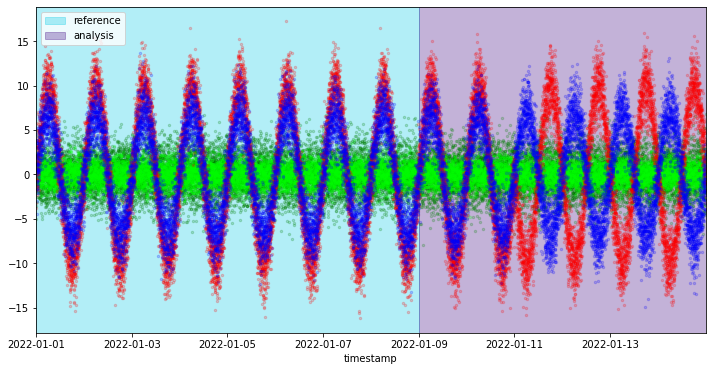

In [5]:
### PLOT GENERATED DATA ###

plt.figure(figsize=(12,6))
plt.axvspan(*list(X[X['partition'] == 'reference'].timestamp.agg(['min','max'])), alpha=0.3, color='#00c8e5', label='reference')
plt.axvspan(*list(X[X['partition'] == 'analysis'].timestamp.agg(['min','max'])), alpha=0.3, color='#3b0280', label='analysis')
X.plot.scatter(x='timestamp', y='X4', alpha=0.2, s=6, c='green', ax=plt.gca())
X.plot.scatter(x='timestamp', y='X3', alpha=0.2, s=6, c='lime', ax=plt.gca())
X.plot.scatter(x='timestamp', y='X2', alpha=0.2, s=6, c='red', ax=plt.gca())
X.plot.scatter(x='timestamp', y='X1', alpha=0.2, s=6, c='blue', ax=plt.gca())
plt.xlim((timestamps[0],timestamps[-1])); plt.legend(); plt.ylabel(None); plt.show()

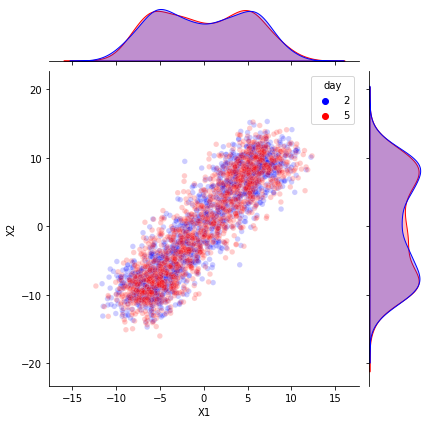

In [6]:
### POSITIVE CORRELATION BETWEEN X1 AND X1 ###

X_plot = pd.concat([X[X.day == 2], X[X.day == 5]], ignore_index=True)
sns.jointplot(data=X_plot, x='X1', y='X2', alpha=0.2, s=30, hue='day', palette='bwr')

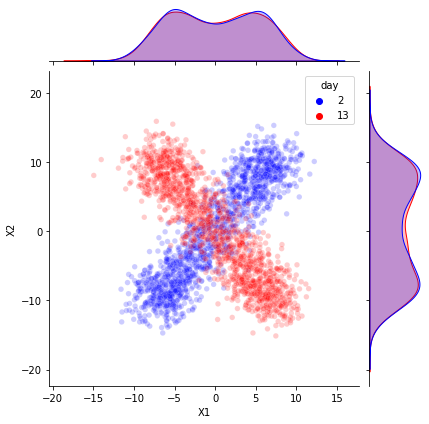

In [7]:
### NEGATIVE CORRELATION BETWEEN X1 AND X1 ###

X_plot = pd.concat([X[X.day == 2], X[X.day == 13]], ignore_index=True)
sns.jointplot(data=X_plot, x='X1', y='X2', alpha=0.2, s=30, hue='day', palette='bwr')

In [8]:
### INITIALIZE NANNYML FOR DRIFT DETECTION ###

metadata = nml.extract_metadata(
    data = X, 
    model_name = 'raw_pca', 
    model_type = 'classification_binary',
    exclude_columns = ['day']
)
metadata.timestamp_column_name = 'timestamp'
metadata.target_column_name = 'y_true'

In [9]:
### COMPUTE UNIVARIATE DRIFT DETECTION ###

univariate_detector = nml.UnivariateStatisticalDriftCalculator(
    model_metadata=metadata, 
    chunk_size=freq
).fit(X[X['partition'] == 'reference'])

univariate_results = univariate_detector.calculate(X)

In [10]:
### PLOT UNIVARIATE DRIFT DETECTION RESULTS ###

for feature in metadata.continuous_features:
    figure = univariate_results.plot(
        kind='feature_distribution',
        feature_label=feature.label
    )
    figure.show()

/opt/conda/lib/python3.7/site-packages/plotly/io/_json.py:471: UserWarning:

Discarding nonzero nanoseconds in conversion



In [11]:
### COMPUTE UNIVARIATE DRIFT DETECTION ###

multivariate_detector = nml.DataReconstructionDriftCalculator(
    model_metadata=metadata, 
    chunk_size=freq,
).fit(X[X['partition'] == 'reference'])

multivariate_results = multivariate_detector.calculate(X)

In [12]:
### PLOT UNIVARIATE DRIFT DETECTION RESULTS ###

figure = multivariate_results.plot()
figure.show()

In [13]:
### OBTAIN RECOSTRUCTION ERRORS FOR EACH FEATURE ###

X_rec = {}

for train_feat in itertools.combinations(features, len(features)-1):

    target_feat = list(set(features).difference(train_feat))[0]
    train_feat = list(train_feat)

    X_train = X[X['partition'] == 'reference'][train_feat].copy()
    y_train = X[X['partition'] == 'reference'][target_feat].copy()
    X_test = X[X['partition'] == 'analysis'][train_feat].copy()

    model = Ridge()
    model.fit(X_train, y_train)

    preds = cross_val_predict(Ridge(), X_train, y_train, cv=KFold(5, shuffle=False))
    preds = np.r_[preds, model.predict(X_test)]

    X_rec[target_feat] = X[target_feat] - preds


X_rec = pd.DataFrame(X_rec)[features]
X_rec['y_true'] = X['y_true'].copy()
X_rec['y_pred_proba'] = X['y_pred_proba'].copy()
X_rec['timestamp'] = X['timestamp'].copy()
X_rec['partition'] = X['partition'].copy()

X_rec.shape

(20160, 8)

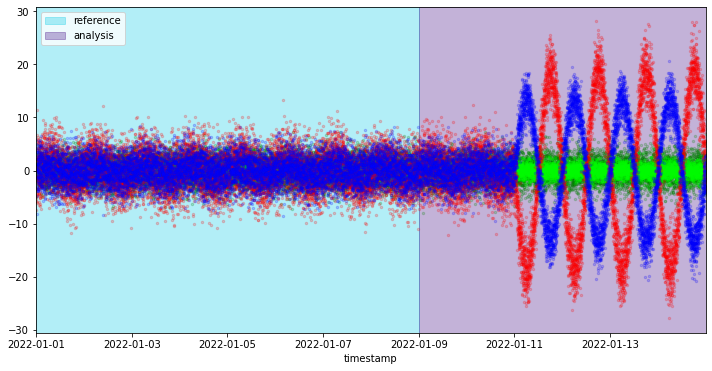

In [14]:
### PLOT RECONSTRUCTION ERROR FOR EACH FEATURE

plt.figure(figsize=(12,6))
plt.axvspan(*list(X_rec[X_rec['partition'] == 'reference'].timestamp.agg(['min','max'])), alpha=0.3, color='#00c8e5', label='reference')
plt.axvspan(*list(X_rec[X_rec['partition'] == 'analysis'].timestamp.agg(['min','max'])), alpha=0.3, color='#3b0280', label='analysis')
X_rec.plot.scatter(x='timestamp', y='X4', alpha=0.2, s=6, c='green', ax=plt.gca())
X_rec.plot.scatter(x='timestamp', y='X3', alpha=0.2, s=6, c='lime', ax=plt.gca())
X_rec.plot.scatter(x='timestamp', y='X2', alpha=0.2, s=6, c='red', ax=plt.gca())
X_rec.plot.scatter(x='timestamp', y='X1', alpha=0.2, s=6, c='blue', ax=plt.gca())
plt.xlim((timestamps[0],timestamps[-1])); plt.legend(); plt.ylabel(None); plt.show()

In [15]:
### INITIALIZE NANNYML FOR DRIFT DETECTION ###

metadata = nml.extract_metadata(
    data = X_rec, 
    model_name = 'rec_pca', 
    model_type = 'classification_binary',
)
metadata.timestamp_column_name = 'timestamp'
metadata.target_column_name = 'y_true'

In [16]:
### COMPUTE UNIVARIATE DRIFT DETECTION ON RESIDUALS ###

univariate_detector = nml.UnivariateStatisticalDriftCalculator(
    model_metadata=metadata, 
    chunk_size=freq
).fit(X_rec[X_rec['partition'] == 'reference'])

univariate_results = univariate_detector.calculate(X_rec)

In [17]:
### PLOT UNIVARIATE DRIFT DETECTION RESULTS ON RESIDUALS ###

for feature in metadata.continuous_features:
    figure = univariate_results.plot(
        kind='feature_distribution',
        feature_label=feature.label
    )
    figure.show()

/opt/conda/lib/python3.7/site-packages/plotly/io/_json.py:471: UserWarning:

Discarding nonzero nanoseconds in conversion

